In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
import h5py
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM import TMCRBM
from scipy.integrate import simps
from scipy import stats


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)
data = torch.tensor(np.genfromtxt('../dataset/data_2d.dat'), device = device, dtype = dtype)

data = (data+1)/2

In [2]:
f = h5py.File("../model/AllParametersRBM_NGibbs_50_Nh100_Ns1000_Nmb600_Nepoch1000_lr_0.01_TMCTEST2D_updCentered_TRUE.h5", 'r')
alltimes = np.array(f['alltime'])
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)

In [3]:
print(alltimes)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 22, 24, 25, 26, 28, 32, 38, 41, 42, 43, 45, 48, 49, 55, 65, 69, 70, 71, 73, 77, 82, 83, 93, 110, 118, 119, 120, 122, 126, 132, 138, 142, 159, 187, 201, 202, 203, 205, 209, 215, 225, 236, 242, 270, 319, 342, 343, 344, 346, 350, 356, 366, 383, 402, 411, 460, 543, 582, 583, 584, 586, 590, 596, 606, 623, 651, 684, 700, 783, 924, 990, 991, 992, 994, 998, 1004, 1014, 1031, 1059, 1108, 1164, 1191, 1332, 1572, 1683, 1684, 1685, 1687, 1691, 1697, 1707, 1724, 1752, 1801, 1884, 1980, 2025, 2265, 2673, 2862, 2863, 2864, 2866, 2870, 2876, 2886, 2903, 2931, 2980, 3063, 3204, 3366, 3444, 3852, 4545, 4866, 4867, 4868, 4870, 4874, 4880, 4890, 4907, 4935, 4984, 5067, 5208, 5448, 5724, 5856, 6549, 7728, 8272, 8273, 8274, 8276, 8280, 8286, 8296, 8313, 8341, 8390, 8473, 8614, 8854, 9262, 9732, 9955, 11134, 13138, 14063, 14064, 14065, 14067, 14071, 14077, 14087, 14104, 14132, 14181, 14264, 14405, 14645, 15053, 15746, 16544, 16925, 18929]


In [4]:
t = 0
lr = 0.1
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 600
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
it_mean = 50
myRBM = TMCRBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )

myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V = torch.svd(myRBM.W)
if torch.mean(V[:,0])<0:
    V = -V
f.close()

In [5]:
# w_hat : nDim x nb_point
# V : matrice de projection
def TMCSampleND(v, w_hat, N, V, it_mcmc=100, it_mean=50, ß=1):
    #print("Initialisation")
    vtab = torch.zeros(v.shape, device=device)
    v_curr = v
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mm(v_curr.T, V)*norm)[:,:w_hat.shape[0]]
    index = torch.randperm(v_curr.shape[0])
    for t in range(it_mcmc):
        #print('init it')
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            s = time.time()
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            for j in range(w_next.shape[1]):
                w_next[:,j] += ((2*v_next[i,:]-1)*V[i,j]*norm)
                
            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*(torch.sum((w_hat.T-w_next)**2, dim=1)-torch.sum((w_hat.T-w_curr)**2, dim=1))

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            neg_index = torch.ones(w_curr.shape[0], dtype = bool)
            index = torch.where(tir<prob)[0]
            neg_index[index] = False
            w_curr[index,:]=  w_next[index, :]
            w_next[neg_index,:] =  w_curr[neg_index,:]
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    vtab = vtab*(1/it_mean)
    vtab = vtab.reshape(Nv, nb_point, nb_chain)
    v_curr = v_curr.reshape(Nv, nb_point, nb_chain)
    h_curr = h_curr.reshape(Nh, nb_point, nb_chain)
    return v_curr, h_curr, vtab

In [6]:
_, s, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g
proj_data =torch.mm(data, V_g).cpu()/myRBM.Nv**0.5


In [7]:
print(s[:4])

tensor([0.0041, 0.0041, 0.0040, 0.0040], device='cuda:0')


In [8]:
nb_chain = 10 # Nb de chaines pour chaque w_hat
it_mcmc = 50 # Nb it_mcmc pour chaque chaine
it_mean = 40 # Nb it considérée pour la moyenne temporelle de chaque chaine
nDim = 2
nb_point_dim = torch.tensor([50,50]) # -> doit avoir autant de terme que la valeur de nDim
N = 20000 # Contrainte
#nb_point_x = 125 # Nb de points de discrétisation pour w_hat
#nb_point_y = 125
width_plus = .2
limits = torch.zeros((2, nDim))
for i in range(nDim):
    limits[0, i] = proj_data[:,i].min()-width_plus
    limits[1, i] = proj_data[:,i].max()+width_plus

xmin = proj_data[:,0].min()-width_plus
xmax = proj_data[:,0].max()+width_plus
ymin = proj_data[:,1].min()-width_plus
ymax = proj_data[:,1].max()+width_plus
nb_point = nb_point_dim.prod()

In [9]:
x_grid = np.linspace(limits[0,0], limits[1,0], nb_point_dim[0])
x_grid = np.array([x_grid for i in range(nb_point_dim[1])])
x_grid = x_grid.reshape(nb_point)
y_grid = []
y_d = np.linspace(limits[0,1], limits[1,1], nb_point_dim[1])
for i in range(nb_point_dim[1]):
    for j in range(nb_point_dim[0]):
        y_grid.append(y_d[i])
grid = torch.tensor([x_grid, y_grid], device = device, dtype = dtype)
grid.shape

torch.Size([2, 2500])

In [10]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = grid
w_hat = torch.zeros((2, nb_chain*nb_point), device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[:,i*nb_chain+j] = w_hat_b[:,i]
tmpv, tmph, vtab = TMCSampleND(start, w_hat, N, V_g, it_mcmc = it_mcmc, it_mean=it_mean)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [11]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 1000), device=myRBM.device, dtype=myRBM.dtype))
#vinit = torch.where(V_g[:,0]>0, 1, 0).repeat(2000).reshape(myRBM.Nv, 2000).float()
#vinit = data.T
si, _, _, _ = myRBM.Sampling(vinit, it_mcmc=10000)
proj_gen = torch.mm(si.T, V_g).cpu().numpy()/Nv**.5
proj_data = torch.mm(data, V_g).cpu().numpy()/Nv**.5

In [12]:
newy = torch.mm(torch.mean(vtab, dim = 2).T, V_g)[:,:nDim]/myRBM.Nv**0.5
#y = torch.mm(vtab.T, V_g)[:,:nDim]/myRBM.Nv**0.5
#newy = torch.tensor([torch.mean(y[i*nb_chain:i*nb_chain+nb_chain,:], dim = 0).cpu().numpy() for i in range(nb_point)])
#w_hat = w_hat.cpu().numpy()
#w_hat_b = w_hat_b.cpu().numpy()

In [13]:
grad_pot = newy.T-w_hat_b
square = torch.zeros(2, nb_point_dim[0], nb_point_dim[1])
w_hat_tmp = np.zeros((2, nb_point_dim[0], nb_point_dim[1]))
for i in range(0,grad_pot.shape[1], nb_point_dim[0]):
        #print(\"I : \", i/nb_point_x)
        #print(\"s : \", (i*nb_point_x))
        #print(\"e : \", (i*nb_point_x+nb_point_x))
        w_hat_tmp[:,:,int(i/nb_point_dim[0])] = w_hat_b[:, i:(i+nb_point_dim[0])].cpu().numpy()
        #print(w_hat_b[:, i:(i+nb_point_dim[0])].cpu().numpy())
        square[:,:, int(i/nb_point_dim[0])] = grad_pot[:,i:(i+nb_point_dim[0])]
#square = grad_pot.reshape(2,nb_point_dim[0], nb_point_dim[1])
w_hat_dim = []
for i in range(nDim):
    w_hat_dim.append(np.linspace(limits[0,i], limits[1,i], nb_point_dim[i]))

res_x = np.zeros(nb_point_dim[0])
for i in range(nb_point_dim[0]):
    res_x[i] = simps(square[0][:(i+1),0].cpu().numpy(), w_hat_tmp[0,:(i+1),0])
res_y = np.zeros((nb_point_dim[0], nb_point_dim[1]))
for i in range(nb_point_dim[0]):
    for j in range(nb_point_dim[1]):
        res_y[i,j] = simps(square[1][i,:(j+1)].cpu().numpy(), w_hat_tmp[1,i,:(j+1)])

pot = np.expand_dims(res_x, 1).repeat(nb_point_dim[1],1) + res_y    
res = np.exp(N*(pot-np.max(pot)))

In [14]:
#LE CALCUL DE LA CONSTANTE EST CORRECT
const = np.zeros(res.shape[0])
for i in range(res.shape[0]):
    const[i-1] = simps(res[:,i], w_hat_tmp[1, i, :])
const = simps(const, w_hat_tmp[0,:,0])
p_m = res/const

In [15]:
tmp = np.zeros(p_m.shape[0])
for i in range( p_m.shape[0]):
    tmp[i] = simps(p_m[:,i], w_hat_dim[1])
tmp = simps(tmp, w_hat_dim[0])
print("Integrale de la proba sur l'espace : ", tmp)

Integrale de la proba sur l'espace :  0.9999999999311526


In [16]:
s_i = torch.mean(tmpv, dim = 2)
tau_a = torch.mean(tmph, dim = 2)
s_i_square = torch.zeros([s_i.shape[0], nb_point_dim[0], nb_point_dim[1]])
tau_a_square = torch.zeros([tau_a.shape[0], nb_point_dim[0], nb_point_dim[1]])

for i in range(0,grad_pot.shape[1], nb_point_dim[0]):
    s_i_square[:,:,int(i/nb_point_dim[0])] = s_i[:, i:(i+nb_point_dim[0])]
    tau_a_square[:,:,int(i/nb_point_dim[0])] = tau_a[:, i:(i+nb_point_dim[0])]
    

In [17]:
prod = torch.zeros(
    (Nv, Nh, nb_point), device=device)
tmpcompute = torch.zeros(Nv, Nh, nb_chain)
s = time.time()
for i in range(nb_point):
    for k in range(nb_chain):
        tmpcompute[:,:,k] = torch.outer(tmpv[:, i, k], tmph[:, i, k])
    prod[:, :, i] = torch.mean(tmpcompute, dim = 2)
print("si tau_a prod : ", time.time()-s)
#prod = torch.stack([torch.mean(
#    prod[:, :, i*self.nb_chain:i*self.nb_chain+self.nb_chain], dim=2) for i in range(self.nb_point)], 2)

p_m = torch.tensor(p_m, device = device)
s_i_square = torch.zeros([s_i.shape[0], nb_point_dim[0], nb_point_dim[1]], device=device, dtype=dtype)
tau_a_square = torch.zeros([tau_a.shape[0], nb_point_dim[0], nb_point_dim[1]], device=device, dtype=dtype)
prod_square = torch.zeros((prod.shape[0], prod.shape[1], nb_point_dim[0], nb_point_dim[1]), device=device, dtype=dtype)
for i in range(0,grad_pot.shape[1], nb_point_dim[0]):
    s_i_square[:,:,int(i/nb_point_dim[0])] = s_i[:, i:(i+nb_point_dim[0])]
    tau_a_square[:,:,int(i/nb_point_dim[0])] = tau_a[:, i:(i+nb_point_dim[0])]
    prod_square[:,:,:,int(i/nb_point_dim[0])] = prod[:, :, i:(i+nb_point_dim[0])]

tmpres_s_i = torch.zeros(Nv, nb_point_dim[0], device=device, dtype=dtype)
tmpres_tau_a = torch.zeros(Nh, nb_point_dim[0], device=device, dtype=dtype)
tmpres_prod = torch.zeros((prod_square.shape[0], prod_square.shape[1], prod_square.shape[2]), device=device, dtype=dtype)
s_i_square = p_m*s_i_square #Ca fait bien ce qu'on veut
tau_a_square = p_m*tau_a_square
prod_square = p_m*prod_square
s_i_fin = torch.zeros(Nv, device=device, dtype=dtype)
tau_a_fin = torch.zeros(Nh, device=device, dtype=dtype)
prod_fin = torch.zeros(prod_square.shape[0], prod_square.shape[1], device=device, dtype=dtype)
for i in range(nb_point_dim[0]):
    tmpres_s_i[:,i] = torch.trapz(s_i_square[:,i,:], torch.tensor(w_hat_dim[1], device=device, dtype=dtype))
    tmpres_tau_a[:,i] = torch.trapz(tau_a_square[:,i,:], torch.tensor(w_hat_dim[1], device=device, dtype=dtype))
    tmpres_prod[:,:,i] = torch.trapz(prod_square[:,:,i,:], torch.tensor(w_hat_dim[1], device=device, dtype=dtype))
tau_a_fin = torch.trapz(tmpres_tau_a, torch.tensor(w_hat_dim[0], device=device, dtype=dtype))
s_i_fin = torch.trapz(tmpres_s_i, torch.tensor(w_hat_dim[0], device=device, dtype=dtype))
prod_fin = torch.trapz(tmpres_prod, torch.tensor(w_hat_dim[0], device=device, dtype=dtype))

si tau_a prod :  5.275836944580078


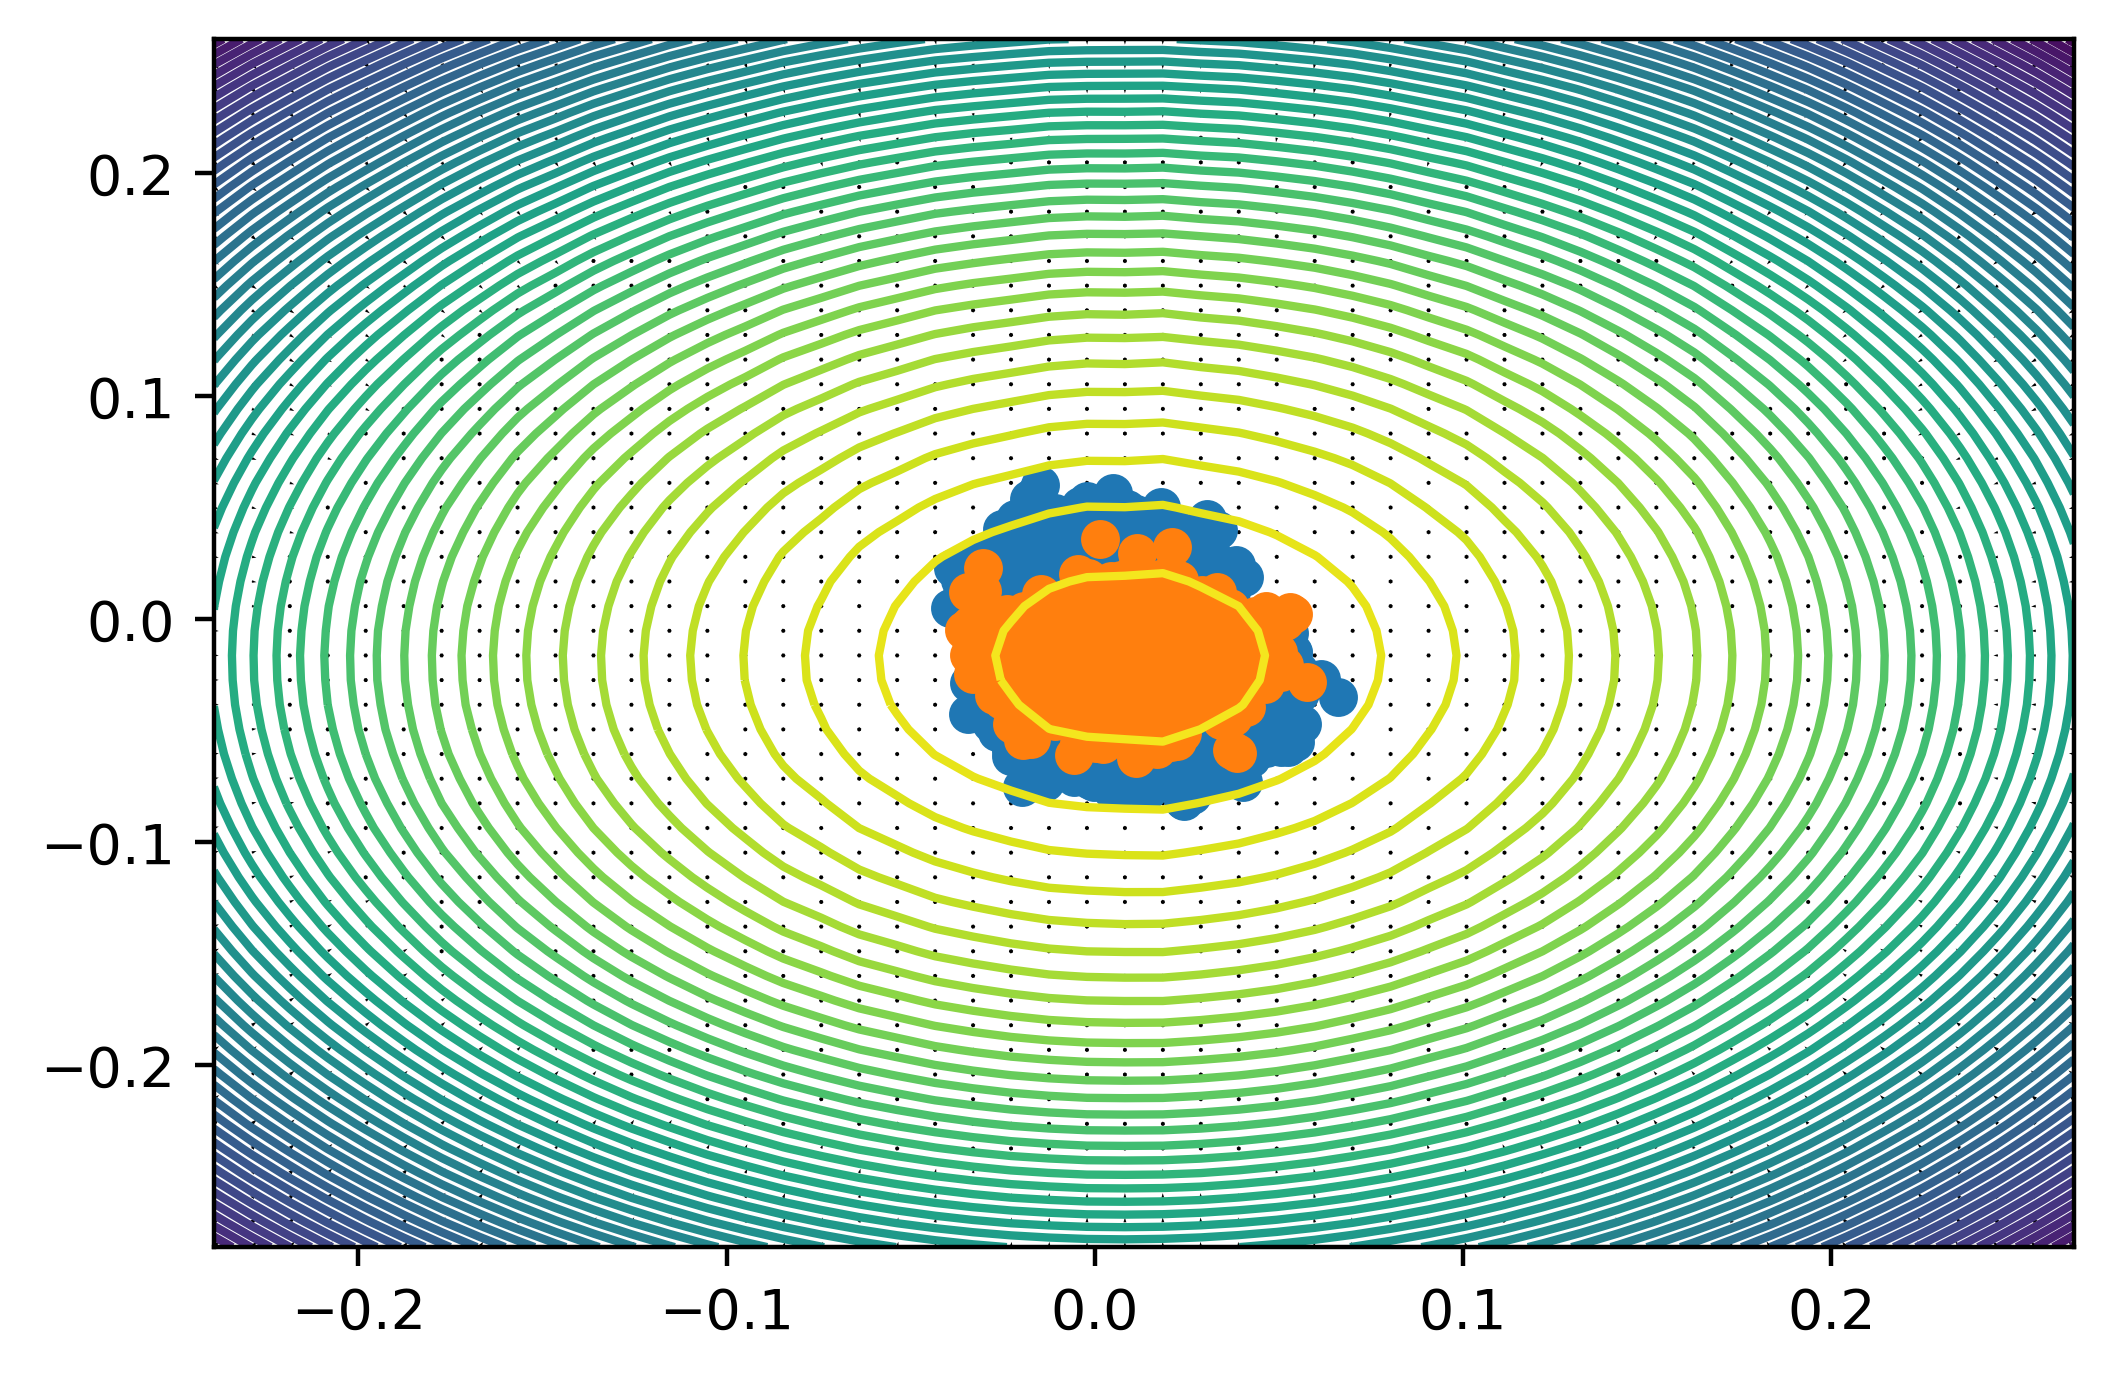

In [18]:
X, Y = np.meshgrid(w_hat_dim[0], w_hat_dim[1])

plt.figure(dpi=400)
plt.quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
plt.contour(w_hat_tmp[0],w_hat_tmp[1], pot, 50)
plt.scatter(proj_data[:,0], proj_data[:,1])
plt.scatter(proj_gen[:,0], proj_gen[:,1])

In [20]:
tmp.shape

()

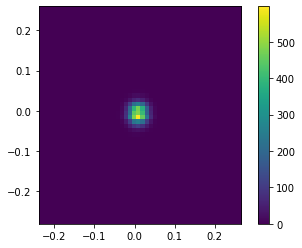

In [24]:
plt.imshow(p_m.cpu(), extent = [limits[0,0], limits[1,0], limits[0,1], limits[1,1]])
plt.colorbar()

[]

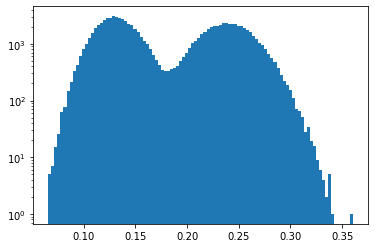

In [25]:
plt.hist(prod_fin.cpu().numpy().reshape(Nv*Nh), bins = 100);
plt.semilogy()

In [26]:
X = myRBM.getMiniBatches(data.T, 15)
v_pos = X
h_pos_v, h_pos_m = myRBM.SampleHiddens01(X)

In [27]:

X_pc, _, h_neg_v, h_neg_m = myRBM.GetAv()
_, _, h_neg_v_, h_neg_m_ = myRBM.GetAv()
v_neg = X_pc
v_neg_ = X_pc

h_neg_v_save = h_neg_v.clone()
NegTerm_ia = h_neg_v.mm(v_neg.t())
NegTerm_ia_bad = h_neg_v.mm(v_neg.t())
VisDataAv = torch.mean(v_pos, 1)
HidDataAv = torch.mean(h_pos_m, 1)
Xc_pos = (v_pos.t() - VisDataAv).t()
Hc_pos = (h_pos_m.t() - HidDataAv).t()

Xc_neg = (v_neg.t() - VisDataAv).t()
Hc_neg = (h_neg_m.t() - HidDataAv).t()

NormPos = 1.0/mb_s
NormNeg = 1.0/num_pcd
# NormL2 = self.regL2

siτa_neg = Hc_neg.mm(Xc_neg.t())*NormNeg
si_neg = torch.sum(v_neg, 1)*NormNeg
τa_neg = torch.sum(h_neg_m, 1)*NormNeg

ΔW = Hc_pos.mm(Xc_pos.t())*NormPos - siτa_neg

ΔW_neg_test = NegTerm_ia*NormNeg - torch.outer(torch.mean(h_neg_m,1).float(), VisDataAv) - \
            torch.outer(HidDataAv, torch.mean(v_neg,1)) + torch.outer(HidDataAv, VisDataAv)

ΔW_neg_test_bad = NegTerm_ia_bad*NormNeg - torch.outer(torch.mean(h_neg_v,1).float(), VisDataAv) - \
            torch.outer(HidDataAv, torch.mean(v_neg,1)) + torch.outer(HidDataAv, VisDataAv)

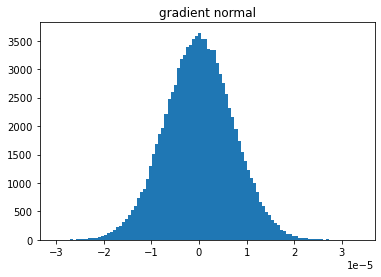

In [28]:
plt.hist(siτa_neg.cpu().numpy().reshape(Nv*Nh), bins = 100);
# plt.hist(NegTerm_ia.cpu().numpy().reshape(Nv*Nh)*NormNeg, bins = 80,density=True);
plt.title("gradient normal");

In [29]:
torch.mean(h_neg_v,1)

tensor([0.5033, 0.4700, 0.4783, 0.5100, 0.5017, 0.4950, 0.5267, 0.5117, 0.4933,
        0.4767, 0.4917, 0.5217, 0.5567, 0.4817, 0.5133, 0.4900, 0.4883, 0.5033,
        0.5067, 0.5267, 0.5117, 0.5333, 0.4983, 0.5067, 0.5350, 0.4950, 0.4917,
        0.5167, 0.5433, 0.4617, 0.5067, 0.4917, 0.4967, 0.4950, 0.5067, 0.5017,
        0.4750, 0.5150, 0.4883, 0.4967, 0.4800, 0.5050, 0.5150, 0.5433, 0.5150,
        0.4783, 0.4783, 0.4933, 0.4600, 0.4867, 0.4933, 0.5217, 0.4950, 0.4917,
        0.4833, 0.5000, 0.4933, 0.4950, 0.5117, 0.5000, 0.4683, 0.5017, 0.4750,
        0.5367, 0.5067, 0.5067, 0.4883, 0.4883, 0.5067, 0.4833, 0.5550, 0.5233,
        0.5000, 0.5300, 0.5067, 0.4933, 0.5267, 0.4800, 0.4600, 0.4767, 0.5067,
        0.5200, 0.4683, 0.5150, 0.5200, 0.4967, 0.5050, 0.5017, 0.5133, 0.4967,
        0.4850, 0.4733, 0.4600, 0.5083, 0.4817, 0.5150, 0.4900, 0.5383, 0.5067,
        0.4867], device='cuda:0')

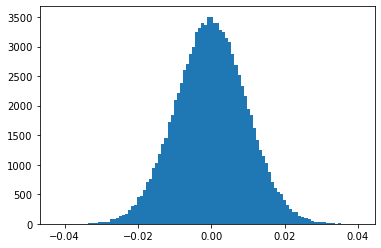

In [30]:
plt.hist((ΔW_neg_test_bad).cpu().numpy().reshape(Nv*Nh), bins = 100);

[]

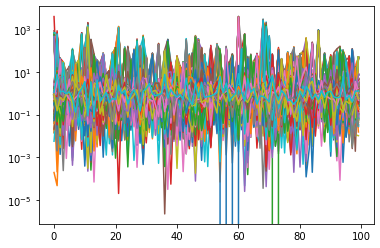

In [31]:
plt.plot(torch.abs(ΔW_neg_test_bad/ΔW_neg_test).cpu().numpy());
plt.semilogy()

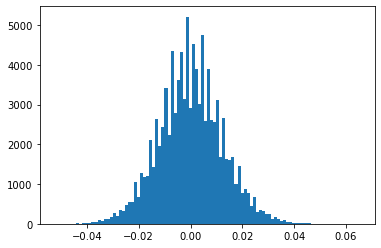

In [32]:
plt.hist(ΔW_neg_test.cpu().numpy().reshape(Nv*Nh), bins = 100);

In [33]:
xxxx = (h_neg_v.mm(v_neg.t())/600 - h_neg_m.mm(v_neg.t())/600)

In [34]:
y=torch.outer(torch.mean(h_neg_v,1).float(), VisDataAv) - torch.outer(torch.mean(h_neg_m,1).float(), VisDataAv)

In [35]:
yy=torch.mean(h_neg_v,1).float() - torch.mean(h_neg_m,1).float()

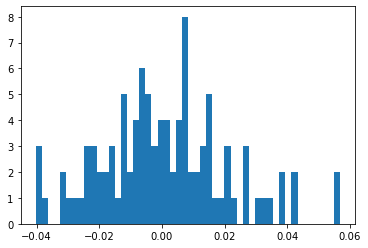

In [36]:
plt.hist(yy.reshape(100).cpu().numpy(),bins=50);

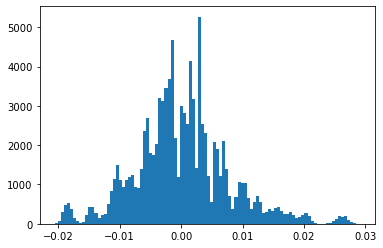

In [37]:
plt.hist(y.reshape(100000).cpu().numpy(),bins=100);

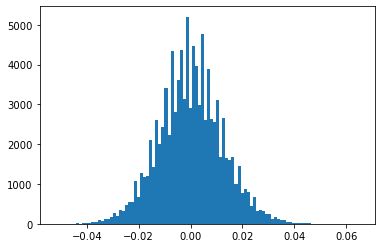

In [38]:
plt.hist(xxxx.reshape(100000).cpu().numpy(),bins=100);

In [39]:
1/600**0.5

0.040824829046386304

In [40]:
print(v_neg.shape)
print(torch.mean(h_neg_v,1).shape)
VIS = VisDataAv.repeat(600,1).T

torch.Size([1000, 600])
torch.Size([100])


In [41]:
(v_neg - VIS)

tensor([[-0.4350,  0.5650,  0.5650,  ...,  0.5650, -0.4350,  0.5650],
        [-0.2617, -0.2617, -0.2617,  ..., -0.2617, -0.2617,  0.7383],
        [ 0.5433,  0.5433,  0.5433,  ...,  0.5433, -0.4567,  0.5433],
        ...,
        [-0.2317, -0.2317,  0.7683,  ..., -0.2317, -0.2317, -0.2317],
        [-0.4483,  0.5517,  0.5517,  ..., -0.4483,  0.5517, -0.4483],
        [-0.2450,  0.7550, -0.2450,  ..., -0.2450,  0.7550, -0.2450]],
       device='cuda:0')

In [42]:
Xc_neg

tensor([[-0.4350,  0.5650,  0.5650,  ...,  0.5650, -0.4350,  0.5650],
        [-0.2617, -0.2617, -0.2617,  ..., -0.2617, -0.2617,  0.7383],
        [ 0.5433,  0.5433,  0.5433,  ...,  0.5433, -0.4567,  0.5433],
        ...,
        [-0.2317, -0.2317,  0.7683,  ..., -0.2317, -0.2317, -0.2317],
        [-0.4483,  0.5517,  0.5517,  ..., -0.4483,  0.5517, -0.4483],
        [-0.2450,  0.7550, -0.2450,  ..., -0.2450,  0.7550, -0.2450]],
       device='cuda:0')

In [43]:
_, _, V_d = torch.svd(data.T)

In [45]:
w_hat_dim[0]

array([-0.23925   , -0.22894029, -0.21863058, -0.20832086, -0.19801115,
       -0.18770144, -0.17739172, -0.16708201, -0.1567723 , -0.14646259,
       -0.13615287, -0.12584316, -0.11553345, -0.10522373, -0.09491402,
       -0.08460431, -0.07429459, -0.06398488, -0.05367517, -0.04336545,
       -0.03305574, -0.02274603, -0.01243631, -0.0021266 ,  0.00818311,
        0.01849283,  0.02880254,  0.03911225,  0.04942197,  0.05973168,
        0.07004139,  0.08035111,  0.09066082,  0.10097053,  0.11128025,
        0.12158996,  0.13189967,  0.14220939,  0.1525191 ,  0.16282881,
        0.17313852,  0.18344824,  0.19375795,  0.20406766,  0.21437738,
        0.22468709,  0.2349968 ,  0.24530652,  0.25561623,  0.26592594])

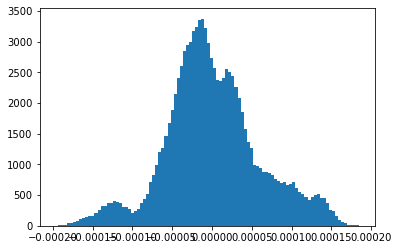

In [46]:
plt.hist(ΔW.cpu().numpy().reshape(Nv*Nh), bins = 100);

In [47]:
V_g.shape

torch.Size([1000, 100])

In [48]:
v_neg = s_i_fin
h_neg_v = tau_a_fin
h_neg_m = prod_fin.T
VisDataAv = torch.mean(v_pos, 1).float()
HidDataAv = torch.mean(h_pos_m, 1).float()    

NormPos = 1.0/mb_s
#NormNeg = 1.0/self.num_pcd


Xc_pos = (v_pos.t() - VisDataAv).t()
Hc_pos = (h_pos_m.t() - HidDataAv).t()

si_neg = v_neg
τa_neg = h_neg_v
print(h_neg_v.shape)
print(VisDataAv.shape)
print(v_neg.shape)
print(HidDataAv.shape)
print(torch.outer(HidDataAv, VisDataAv).shape)
# ΔW_neg = h_neg_m - torch.outer(h_neg_v.float(), VisDataAv) - torch.outer(HidDataAv, v_neg) + torch.outer(HidDataAv, VisDataAv)
ΔW_neg = h_neg_m - torch.outer(torch.mean(h_neg_v_,1).float(), VisDataAv) - torch.outer(HidDataAv, torch.mean(v_neg_,1)) + torch.outer(HidDataAv, VisDataAv)
ΔW = Hc_pos.mm(Xc_pos.t())*NormPos - ΔW_neg


torch.Size([100])
torch.Size([1000])
torch.Size([1000])
torch.Size([100])
torch.Size([100, 1000])


In [49]:
h_neg_v

tensor([0.5165, 0.4753, 0.4505, 0.5179, 0.5537, 0.4829, 0.5151, 0.5083, 0.5169,
        0.5118, 0.5261, 0.4952, 0.4264, 0.5455, 0.5374, 0.4674, 0.5226, 0.4687,
        0.4791, 0.4850, 0.4744, 0.5097, 0.5142, 0.4397, 0.5261, 0.4881, 0.5244,
        0.5375, 0.4772, 0.5573, 0.5340, 0.5193, 0.5341, 0.4578, 0.4895, 0.5105,
        0.5375, 0.5637, 0.5135, 0.5229, 0.5269, 0.4672, 0.4746, 0.5082, 0.4609,
        0.4933, 0.4822, 0.4868, 0.5413, 0.5521, 0.4949, 0.5292, 0.4967, 0.5154,
        0.4592, 0.5044, 0.5459, 0.4771, 0.4575, 0.4793, 0.4604, 0.5137, 0.5003,
        0.5030, 0.5110, 0.5293, 0.4694, 0.5402, 0.5189, 0.5076, 0.4997, 0.5213,
        0.5044, 0.5045, 0.4845, 0.4712, 0.5576, 0.4445, 0.5308, 0.4892, 0.5344,
        0.5092, 0.5291, 0.5679, 0.5155, 0.4540, 0.5127, 0.5088, 0.5125, 0.4963,
        0.4813, 0.4869, 0.4882, 0.5235, 0.4594, 0.4929, 0.4964, 0.5598, 0.5029,
        0.5127], device='cuda:0')

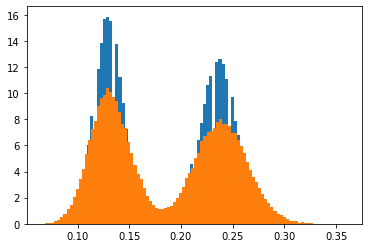

In [50]:
plt.hist(NegTerm_ia.cpu().numpy().reshape(Nv*Nh)*NormNeg, bins = 80,density=True);
plt.hist(prod_fin.cpu().numpy().reshape(Nv*Nh), bins =100,density=True);

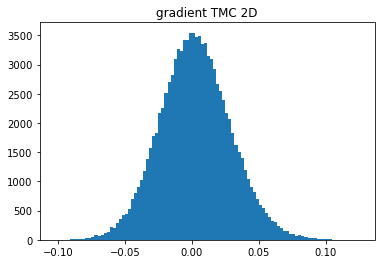

In [51]:
plt.hist(ΔW_neg.cpu().numpy().reshape(Nv*Nh), bins = 100);
# plt.hist(prod_fin.cpu().numpy().reshape(Nv*Nh), bins =100,density=True);
plt.title("gradient TMC 2D");

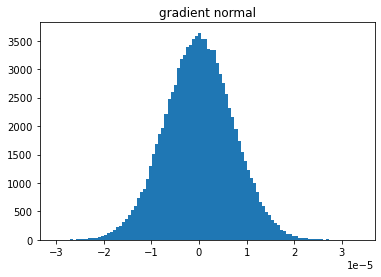

In [52]:
plt.hist(siτa_neg.cpu().numpy().reshape(Nv*Nh), bins = 100);
# plt.hist(NegTerm_ia.cpu().numpy().reshape(Nv*Nh)*NormNeg, bins = 80,density=True);
plt.title("gradient normal");

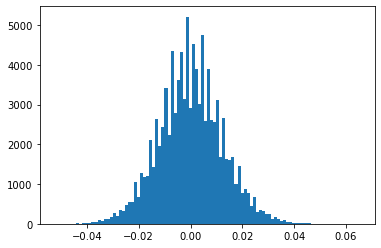

In [53]:
plt.hist(ΔW_neg_test.cpu().numpy().reshape(Nv*Nh), bins = 100);

Text(0.5, 1.0, 'negTermV')

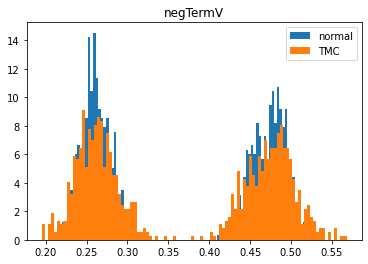

In [60]:
plt.hist(torch.mean(X_pc, 1).cpu().numpy(), density = True, bins = 100, label = "normal");
plt.hist(s_i_fin.cpu().numpy(), density = True, bins = 100, label = "TMC");
plt.legend()
plt.title("negTermV")

Text(0.5, 1.0, 'negTermV')

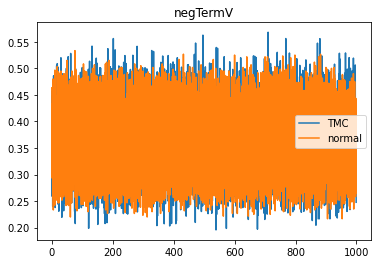

In [55]:
plt.plot(s_i_fin.cpu(), label = "TMC")
plt.plot(torch.mean(X_pc, 1).cpu().numpy(), label = "normal")

plt.legend()
plt.title("negTermV")

Text(0.5, 1.0, 'negTermV')

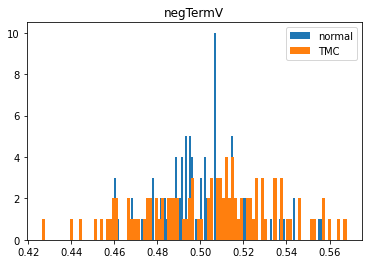

In [57]:
plt.hist(torch.mean(h_neg_v_save, 1).cpu().numpy(), label = "normal", bins =100)
plt.hist(tau_a_fin.cpu().numpy(), label = "TMC", bins =100)
plt.legend()
plt.title("negTermH")

Text(0.5, 1.0, 'negTermH')

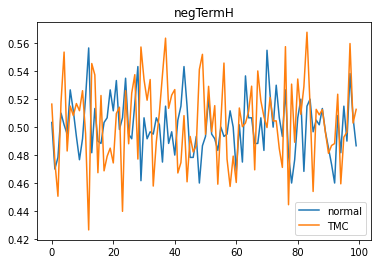

In [59]:
plt.plot(torch.mean(h_neg_v_save, 1).cpu().numpy(), label = "normal")
plt.plot(tau_a_fin.cpu().numpy(), label = "TMC")
plt.legend()
plt.title("negTermH")

In [ ]:
s_i.shape

In [ ]:
for k in range(100):
    print('-------------- : ', torch.mm(s_i[:,k].unsqueeze(1).T, V_g)[:,0])
    for i in range(10):
        proj = torch.mm(tmpv[:,k,i].unsqueeze(1).T, V_g)
        print(proj[:,0])
